In [2]:
import tsflex
print(tsflex.__version__)

0.1.2.5


## Get the data

In [3]:
import pandas as pd

url = "https://github.com/predict-idlab/tsflex/raw/main/examples/data/empatica/"
df_tmp = pd.read_parquet(url+"tmp.parquet").set_index("timestamp")
df_acc = pd.read_parquet(url+"acc.parquet").set_index("timestamp")
df_gsr = pd.read_parquet(url+"gsr.parquet").set_index("timestamp")
df_ibi = pd.read_parquet(url+"ibi.parquet").set_index("timestamp")

In [4]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Sampling rate: 4.0 Hz

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Sampling rate: 32.0 Hz

Time-series: ['EDA']
(30204, 1)
Sampling rate: 4.0 Hz

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data]
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

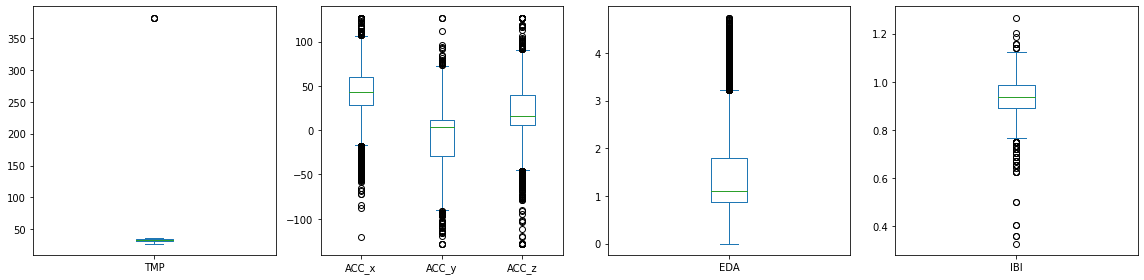

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of notebook containing the example code of the paper.

In [7]:
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Import / create the processing functions
import numpy as np
from scipy.signal import savgol_filter

def clip_quantiles(sig: pd.Series, lower_q=0.01, upper_q=0.99) -> np.ndarray:
    # Note that this function induces a data leakage
    quantile_vals = np.quantile(sig, q=[lower_q, upper_q])
    return np.clip(sig, *quantile_vals)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
clipper_tmp = SeriesProcessor(clip_quantiles, series_names="TMP", lower_q=0, upper_q=0.999)
savgol_eda = SeriesProcessor(savgol_filter, "EDA", window_length=5, polyorder=2)
savgol_acc = SeriesProcessor(savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2)
smv_processor = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline
series_pipe = SeriesPipeline(
    processors=[clipper_tmp, savgol_eda, savgol_acc, smv_processor]
)
series_pipe

[
	clip_quantiles {'lower_q': 0, 'upper_q': 0.999} :  ('TMP',)
	savgol_filter {'window_length': 5, 'polyorder': 2} :  ('EDA',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [8]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

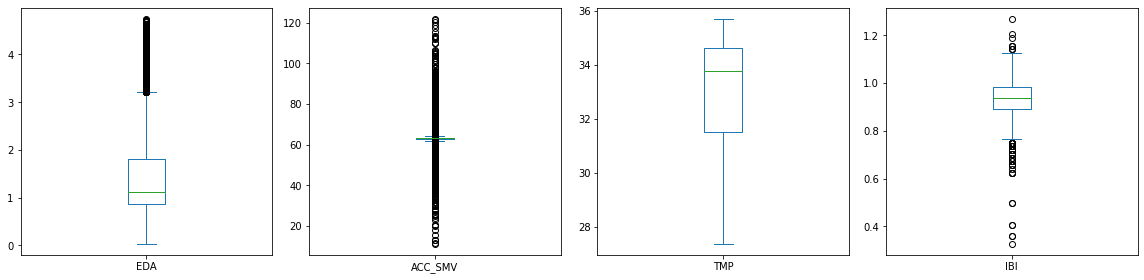

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [tsfresh](https://github.com/blue-yonder/tsfresh) integration

In [ ]:
!pip install tsfresh

> Useful links;
> [List of all tsfresh features](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)  
> [More detailed documentation of the tsfresh features](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#module-tsfresh.feature_extraction.feature_calculators)  
> [More detailed documentation of the tsfresh feature extraction settings](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)

[tsfresh feature extraction settings](https://github.com/blue-yonder/tsfresh/blob/main/tsfresh/feature_extraction/settings.py) is how tsfresh represents a collection of features (with their parameters).  
**=> requires wrapping this settings object in a `tsfresh_settings_wrapper` for interoperability with tsflex**.

[tsfresh feature-funtions](https://github.com/blue-yonder/tsfresh/blob/main/tsfresh/feature_extraction/feature_calculators.py) are either of type `simple` or `combiner`.
* `simple`: feature calculators which calculate a single number  
  **=> integrates natively with tsflex**
* `combiner`: feature calculates which calculate a bunch of features for a list of parameters. These features are returned as a list of (key, value) pairs for each input parameter.  
  **=> requires wrapping the function to only extract the values of the returned tuples**  
  
Of course, feature functions that require other keyword arguments, should be wrapped in a `FuncWrapper`

In [11]:
# This wrapper handles tsfresh its feature extraction settings
from tsflex.features.integrations import tsfresh_settings_wrapper
# This wrappers handles tsfresh its combiner functions
from tsflex.features.integrations import tsfresh_combiner_wrapper

In [12]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors

## Using tsfresh feature extraction settings

In [13]:
# Import some preset feature extraction setting from tsfresh
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

Calculate the features for a tsfresh feature extraction setting.  
Note that;
* `tsfresh_settings_wrapper` transforms this feature extraction settings object to a list of features that you can directly pass as the `function` argument of tsflex `MultipleFeatureDescriptors`.

In [14]:
simple_feats = MultipleFeatureDescriptors(
    functions=tsfresh_settings_wrapper(MinimalFCParameters()),
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(simple_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(sum_values, ['sum_values'], {}),
		FeatureDescriptor - func: FuncWrapper(median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper(length, ['length'], {}),
		FeatureDescriptor - func: FuncWrapper(standard_deviation, ['standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(variance, ['variance'], {}),
		FeatureDescriptor - func: FuncWrapper(root_mean_square, ['root_mean_square'], {}),
		FeatureDescriptor - func: FuncWrapper(maximum, ['maximum'], {}),
		FeatureDescriptor - func: FuncWrapper(minimum, ['minimum'], {}),
	]
	win: 2m30s , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(sum_values, ['sum_values'], {}),
		FeatureDescriptor - func: FuncWrapper(median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper(length, ['length'], {}),
		FeatureDescriptor

In [15]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/54 [00:00<?, ?it/s]

,ACC_SMV__length__w=5m_s=2m30s,ACC_SMV__sum_values__w=5m_s=2m30s,ACC_SMV__mean__w=5m_s=2m30s,ACC_SMV__variance__w=5m_s=2m30s,ACC_SMV__maximum__w=5m_s=2m30s,ACC_SMV__standard_deviation__w=5m_s=2m30s,ACC_SMV__root_mean_square__w=5m_s=2m30s,ACC_SMV__sum_values__w=2m30s_s=2m30s,ACC_SMV__minimum__w=5m_s=2m30s,ACC_SMV__median__w=5m_s=2m30s,...,TMP__minimum__w=2m30s_s=2m30s,TMP__root_mean_square__w=2m30s_s=2m30s,EDA__median__w=5m_s=2m30s,TMP__median__w=2m30s_s=2m30s,TMP__standard_deviation__w=2m30s_s=2m30s,TMP__root_mean_square__w=5m_s=2m30s,TMP__variance__w=2m30s_s=2m30s,EDA__variance__w=2m30s_s=2m30s,EDA__standard_deviation__w=5m_s=2m30s,EDA__median__w=2m30s_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302283.632453,NaN,NaN,...,27.370001,27.845297,NaN,27.610001,0.752281,NaN,0.565926,0.004362,NaN,0.528624
2017-06-13 14:27:13+02:00,9600.0,605853.471250,63.109737,10.086518,92.325941,3.175928,63.189599,303569.838797,35.954740,63.092027,...,28.590000,29.254473,0.605353,29.240000,0.300137,28.558577,0.090082,0.022120,0.147707,0.722760
2017-06-13 14:29:43+02:00,9600.0,605584.777954,63.081748,6.117127,92.325941,2.473283,63.130215,302014.939157,44.753951,62.937181,...,29.850000,30.236929,0.861033,30.290001,0.125977,29.749758,0.015870,0.013971,0.143321,0.873219
2017-06-13 14:32:13+02:00,9600.0,603119.889884,62.824989,2.776734,81.441751,1.666353,62.847084,301104.950727,41.660656,62.854726,...,30.410000,30.854300,0.766299,30.790001,0.330085,30.547174,0.108956,0.001381,0.106061,0.715032
2017-06-13 14:34:43+02:00,9600.0,601771.324996,62.684513,2.891151,81.441751,1.700338,62.707570,300666.374269,41.660656,62.635014,...,31.629999,32.328682,0.749746,32.410000,0.366860,31.600092,0.134586,0.004474,0.070785,0.798747
2017-06-13 14:37:13+02:00,9600.0,603388.122920,62.852929,21.744128,121.564172,4.663060,63.025668,302721.748651,11.223471,62.717138,...,32.549999,32.827316,0.866020,32.830002,0.087902,32.578957,0.007727,0.015643,0.101888,0.886410
2017-06-13 14:39:43+02:00,9600.0,604111.198743,62.928250,24.612701,121.564172,4.961119,63.123509,301389.450092,11.223471,62.804672,...,32.290001,32.640171,0.900442,32.660000,0.224348,32.733879,0.050332,0.005297,0.107958,0.920974
2017-06-13 14:42:13+02:00,9600.0,601345.993076,62.640208,4.142356,83.171716,2.035278,62.673264,299956.542984,43.888400,62.503425,...,32.790001,33.107750,0.932704,33.029999,0.275753,32.874790,0.076040,0.002007,0.064949,0.966249
2017-06-13 14:44:43+02:00,9600.0,602804.798114,62.792166,1.560255,74.364764,1.249102,62.804589,302848.255130,45.415474,62.692099,...,33.630001,33.814301,0.911126,33.790001,0.142286,33.462891,0.020245,0.026383,0.144050,0.828835


Extract a lot more tsfresh features (& customize the settings, i.e., remove the slower functions)

In [16]:
slow_funcs = [
"matrix_profile",
"number_cwt_peaks",
"augmented_dickey_fuller",
"partial_autocorrelation",
"agg_linear_trend",
"lempel_ziv_complexity",
"benford_correlation",
"ar_coefficient",
"permutation_entropy",
"friedrich_coefficients",
]

settings = EfficientFCParameters()
for f in slow_funcs:
    del settings[f]

In [17]:
efficient_feats = MultipleFeatureDescriptors(
    functions=tsfresh_settings_wrapper(settings),
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(efficient_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(has_duplicate_max, ['has_duplicate_max'], {}),
		FeatureDescriptor - func: FuncWrapper(has_duplicate_min, ['has_duplicate_min'], {}),
		FeatureDescriptor - func: FuncWrapper(has_duplicate, ['has_duplicate'], {}),
		FeatureDescriptor - func: FuncWrapper(sum_values, ['sum_values'], {}),
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_abs_change, ['mean_abs_change'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_change, ['mean_change'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_second_derivative_central, ['mean_second_derivative_central'], {}),
		FeatureDescriptor - func: FuncWrapper(median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: Fun

In [18]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/1098 [00:00<?, ?it/s]

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:2022: RankWarning:

Polyfit may be poorly conditioned

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/fea

,ACC_SMV__abs_energy__w=5m_s=2m30s,ACC_SMV__has_duplicate_max__w=5m_s=2m30s,ACC_SMV__has_duplicate_min__w=5m_s=2m30s,ACC_SMV__sum_values__w=5m_s=2m30s,ACC_SMV__mean_change__w=5m_s=2m30s,ACC_SMV__variance_larger_than_standard_deviation__w=5m_s=2m30s,ACC_SMV__mean_abs_change__w=5m_s=2m30s,ACC_SMV__mean_second_derivative_central__w=5m_s=2m30s,ACC_SMV__mean__w=5m_s=2m30s,ACC_SMV__length__w=5m_s=2m30s,...,"TMP__fft_coefficient_{'coeff': 91, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 92, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 93, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 94, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 95, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 96, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 97, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 98, 'attr': 'angle'}__w=2m30s_s=2m30s","TMP__fft_coefficient_{'coeff': 99, 'attr': 'angle'}__w=2m30s_s=2m30s","EDA__max_langevin_fixed_point_{'m': 3, 'r': 30}__w=2m30s_s=2m30s"
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-82.120999,-84.149558,-85.268199,-85.756598,-87.351015,-87.851409,-88.450624,-89.580805,-91.252016,0.682016
2017-06-13 14:27:13+02:00,3.833208e+07,False,False,605853.471250,0.000267,True,0.254194,6.800440e-06,63.109737,9600.0,...,117.075936,127.399775,100.525547,123.124305,114.439793,123.532343,109.887673,110.747338,113.608543,0.774249
2017-06-13 14:29:43+02:00,3.826007e+07,False,False,605584.777954,0.000039,True,0.217287,-3.990741e-06,63.081748,9600.0,...,89.781180,134.946838,123.599215,141.737962,135.967402,151.992655,130.313489,156.110224,155.143276,0.918535
2017-06-13 14:32:13+02:00,3.791766e+07,False,False,603119.889884,-0.000385,True,0.098600,-2.059718e-06,62.824989,9600.0,...,103.816010,107.113216,108.148438,122.619805,151.492001,137.097234,116.360572,118.866716,116.165226,0.840035
2017-06-13 14:34:43+02:00,3.774950e+07,False,False,601771.324996,-0.000007,True,0.090840,1.996682e-06,62.684513,9600.0,...,124.803323,121.790317,86.725466,110.540362,140.088107,119.178773,124.755441,127.858606,129.311802,0.880631
2017-06-13 14:37:13+02:00,3.813345e+07,False,False,603388.122920,0.000093,True,0.243560,1.025698e-05,62.852929,9600.0,...,-58.817013,-35.704111,-91.521730,-69.170612,-65.525365,-91.127372,145.387676,6.029741,-43.270130,0.891893
2017-06-13 14:39:43+02:00,3.825194e+07,False,False,604111.198743,-0.000034,True,0.323059,-6.968205e-07,62.928250,9600.0,...,172.889893,177.969779,-64.650175,106.424210,25.771322,-17.035369,23.004309,65.900320,103.468867,0.953050
2017-06-13 14:42:13+02:00,3.770820e+07,False,False,601345.993076,-0.000094,True,0.142898,-1.381123e-05,62.640208,9600.0,...,159.178953,121.199058,127.965060,133.877473,108.377713,142.764688,132.226726,138.105780,141.252310,1.021598
2017-06-13 14:44:43+02:00,3.786640e+07,False,False,602804.798114,0.000056,True,0.080896,-4.024501e-07,62.792166,9600.0,...,98.547041,-145.939775,5.864765,102.901064,28.222315,149.850968,-97.324586,-77.474784,-104.784640,0.802820


### Plot the EDA features

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    if not np.issubdtype(sub_df.values.dtype, np.number):
        continue
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using simple tsfresh features

Integrates natively :)

In [20]:
# Import some simple funtions
from tsfresh.feature_extraction.feature_calculators import (
    abs_energy,
    absolute_sum_of_changes,
    cid_ce,
    variance_larger_than_standard_deviation,
)

from tsflex.features import FeatureCollection, FuncWrapper, MultipleFeatureDescriptors

simple_feats = MultipleFeatureDescriptors(
    functions=[
        abs_energy,
        absolute_sum_of_changes,
        variance_larger_than_standard_deviation,
        FuncWrapper(cid_ce, normalize=True),
    ],
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides="2min",
)
feature_collection = FeatureCollection(simple_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolute_sum_of_changes, ['absolute_sum_of_changes'], {}),
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(cid_ce, ['cid_ce'], {'normalize': True}),
	]
	win: 2m30s , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolute_sum_of_changes, ['absolute_sum_of_changes'], {}),
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(cid_ce, ['cid_ce'], {'normalize': True}),
	]
)
EDA: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolut

In [21]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,EDA__abs_energy__w=2m30s_s=2m,EDA__abs_energy__w=5m_s=2m,ACC_SMV__absolute_sum_of_changes__w=2m30s_s=2m,ACC_SMV__absolute_sum_of_changes__w=5m_s=2m,EDA__absolute_sum_of_changes__w=5m_s=2m,TMP__abs_energy__w=5m_s=2m,ACC_SMV__variance_larger_than_standard_deviation__w=5m_s=2m,ACC_SMV__variance_larger_than_standard_deviation__w=2m30s_s=2m,...,ACC_SMV__cid_ce__w=5m_s=2m,EDA__cid_ce__w=5m_s=2m,EDA__cid_ce__w=2m30s_s=2m,TMP__variance_larger_than_standard_deviation__w=5m_s=2m,TMP__absolute_sum_of_changes__w=5m_s=2m,TMP__abs_energy__w=2m30s_s=2m,TMP__absolute_sum_of_changes__w=2m30s_s=2m,TMP__variance_larger_than_standard_deviation__w=2m30s_s=2m,TMP__cid_ce__w=2m30s_s=2m,TMP__cid_ce__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,184.250092,NaN,845.268541,NaN,NaN,NaN,NaN,True,...,NaN,NaN,5.511241,NaN,NaN,465216.34375,10.389996,False,10.732648,NaN
2017-06-13 14:26:43+02:00,1.919667e+07,NaN,289.237640,NaN,1574.566142,NaN,NaN,NaN,NaN,True,...,NaN,NaN,6.109140,NaN,NaN,504830.37500,2.139997,False,0.638482,NaN
2017-06-13 14:27:13+02:00,NaN,3.833208e+07,NaN,522.025757,NaN,2440.009509,9.694985,978710.875,True,NaN,...,19.582844,6.080983,NaN,False,12.549994,NaN,NaN,NaN,NaN,8.863720
2017-06-13 14:28:43+02:00,1.900028e+07,NaN,455.579346,NaN,481.406374,NaN,NaN,NaN,NaN,True,...,NaN,NaN,3.939107,NaN,NaN,538692.06250,2.180008,False,0.710819,NaN
2017-06-13 14:29:13+02:00,NaN,3.821475e+07,NaN,724.489075,NaN,2126.336744,11.101377,1048903.250,True,NaN,...,20.645812,5.895875,NaN,False,4.400007,NaN,NaN,NaN,NaN,0.546809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,NaN,3.815810e+07,NaN,818.431396,NaN,505.659693,2.052273,1109714.375,False,NaN,...,21.359762,1.291382,NaN,False,4.399990,NaN,NaN,NaN,NaN,0.719703
2017-06-13 16:24:43+02:00,1.910876e+07,NaN,409.383636,NaN,948.203277,NaN,NaN,NaN,NaN,True,...,NaN,NaN,1.692523,NaN,NaN,574609.37500,1.899998,False,4.435842,NaN
2017-06-13 16:25:13+02:00,NaN,3.820289e+07,NaN,861.155273,NaN,1469.749979,4.397668,1141974.500,True,NaN,...,21.927573,2.154354,NaN,False,4.079985,NaN,NaN,NaN,NaN,1.619698


### Plot the EDA features

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using combiner tsfresh features

In [23]:
# Import all combiner funcs
from tsfresh.feature_extraction.feature_calculators import (
    agg_autocorrelation,
    augmented_dickey_fuller,
    cwt_coefficients,
    fft_aggregated,
    fft_coefficient,
    index_mass_quantile,
    linear_trend,
    partial_autocorrelation,
    spkt_welch_density,
    symmetry_looking,
    ar_coefficient,
    friedrich_coefficients,
    agg_linear_trend,
    energy_ratio_by_chunks,
    linear_trend_timewise,
    matrix_profile,
    query_similarity_count,
)

Calculate the features for some of tsfresh its combiner functions.  
Note that;
* `param` is now passed to `tsfresh_combiner_wrapper` instead of the combiner function itself
* combiner functions that require a `pd.Series` (with a `pd.DatetimeIndex`) are also handled by this wrapper

In [24]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors

combiner_feats = MultipleFeatureDescriptors(
    functions=[
        tsfresh_combiner_wrapper(index_mass_quantile, param=[{"q": v} for v in [0.15, 0.5, 0.75]]),
        tsfresh_combiner_wrapper(linear_trend, param=[{"attr": v} for v in ["intercept", "slope", "stderr"]]),
        tsfresh_combiner_wrapper(spkt_welch_density, param=[{"coeff": v} for v in range(5)]),
        # This function requires a pd.Series with a pd.DatetimeIndex
        tsfresh_combiner_wrapper(linear_trend_timewise, param=[{"attr": v} for v in ["intercept", "slope"]]),
    ],
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(combiner_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__index_mass_quantile, ["index_mass_quantile_{'q': 0.15}", "index_mass_quantile_{'q': 0.5}", "index_mass_quantile_{'q': 0.75}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__linear_trend, ["linear_trend_{'attr': 'intercept'}", "linear_trend_{'attr': 'slope'}", "linear_trend_{'attr': 'stderr'}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__spkt_welch_density, ["spkt_welch_density_{'coeff': 0}", "spkt_welch_density_{'coeff': 1}", "spkt_welch_density_{'coeff': 2}", "spkt_welch_density_{'coeff': 3}", "spkt_welch_density_{'coeff': 4}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__linear_trend_timewise, ["linear_trend_timewise_{'attr': 'intercept'}", "linear_trend_timewise_{'attr': 'slope'}"], {}),
	]
	win: 2m30s , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__in

In [25]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,EDA__index_mass_quantile_{'q': 0.15}__w=5m_s=2m30s,EDA__index_mass_quantile_{'q': 0.5}__w=5m_s=2m30s,EDA__index_mass_quantile_{'q': 0.75}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.15}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.5}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.75}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.15}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.5}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.75}__w=5m_s=2m30s,TMP__index_mass_quantile_{'q': 0.15}__w=2m30s_s=2m30s,...,TMP__linear_trend_timewise_{'attr': 'slope'}__w=5m_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'intercept'}__w=2m30s_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'slope'}__w=2m30s_s=2m30s,TMP__linear_trend_timewise_{'attr': 'intercept'}__w=2m30s_s=2m30s,TMP__linear_trend_timewise_{'attr': 'slope'}__w=2m30s_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'intercept'}__w=5m_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'slope'}__w=5m_s=2m30s,ACC_SMV__linear_trend_{'attr': 'intercept'}__w=5m_s=2m30s,ACC_SMV__linear_trend_{'attr': 'slope'}__w=5m_s=2m30s,ACC_SMV__linear_trend_{'attr': 'stderr'}__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,0.149583,0.498333,0.749167,NaN,NaN,NaN,0.150000,...,NaN,63.414533,-21.065657,27.382699,21.753076,NaN,NaN,NaN,NaN,NaN
2017-06-13 14:27:13+02:00,0.192500,0.577500,0.816667,0.148750,0.498958,0.748958,0.149896,0.501146,0.750000,0.153333,...,31.299902,63.755843,-24.587180,28.743725,24.482889,63.146538,-0.883331,63.146538,-7.667800e-06,1.169742e-05
2017-06-13 14:29:43+02:00,0.183333,0.529167,0.751667,0.150208,0.500000,0.750000,0.148542,0.498750,0.749375,0.151667,...,21.282509,62.918468,0.062962,30.150985,4.119556,63.452392,-8.896401,63.452392,-7.722570e-05,9.075504e-06
2017-06-13 14:32:13+02:00,0.134167,0.464167,0.725833,0.149792,0.499167,0.748958,0.149896,0.499271,0.749271,0.153333,...,14.940187,62.977541,-11.874926,30.296854,26.717133,63.028674,-4.888952,63.028674,-4.243882e-05,6.122260e-06
2017-06-13 14:34:43+02:00,0.152500,0.531667,0.775833,0.150417,0.501042,0.751250,0.149688,0.499688,0.750313,0.153333,...,33.566257,62.394385,11.735713,31.712060,29.547285,62.753758,-1.662063,62.753758,-1.442763e-05,6.261009e-06
2017-06-13 14:37:13+02:00,0.163333,0.510833,0.771667,0.150625,0.501667,0.750833,0.150833,0.501771,0.751667,0.150000,...,12.366950,62.788907,13.352729,32.883319,-2.698108,62.401155,10.843709,62.401155,9.412942e-05,1.714823e-05
2017-06-13 14:39:43+02:00,0.156667,0.520000,0.762500,0.149167,0.500208,0.750000,0.150000,0.498854,0.749479,0.151667,...,-1.675625,62.802418,-0.621696,32.299627,16.336348,63.070099,-3.404741,63.070099,-2.955504e-05,1.827046e-05
2017-06-13 14:42:13+02:00,0.158333,0.512500,0.746667,0.150000,0.500625,0.750417,0.150000,0.498854,0.749792,0.151667,...,13.194341,62.392118,4.744749,32.650243,21.941618,62.842604,-4.858020,62.842604,-4.217031e-05,7.484031e-06
2017-06-13 14:44:43+02:00,0.131667,0.455000,0.740833,0.150625,0.501875,0.750625,0.150833,0.502396,0.752188,0.150000,...,14.555505,62.761654,15.926464,33.967144,-7.363225,62.232732,13.427822,62.232732,1.165610e-04,4.444229e-06


### Plot the EDA features

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')